# AI6126 ACV Project 1


In [1]:
nb_ver = 0.6
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "FL"
print(comments)

ai6126-project1-colab-v0.6
FL


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (BinaryFocalLoss)

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

## Setup/ Configuration

### Colab

In [2]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [3]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne

In [6]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing()
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [10]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrResNet']


In [11]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    model = model.to(device)
    return model
#print(model)

### Criterion & Optimizer

In [12]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(0.25, reduction='sum').to(device)
    return criterion
# criterion = nn.CrossEntropyLoss().to(device)

# optimizer = torch.optim.SGD(model.parameters(), config.lr,
#                             momentum=config.momentum,
#                             weight_decay=config.weight_decay)

### Resume Checkpoint if any

In [13]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1 = model.load_ckp(optimizer, ckp_resume)
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, start_epoch, logger

## Train & Validate Function

In [14]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)):
            crit = criterion(output[j], y[:, j])
            print(crit.detach())
            loss.append(criterion(output[j], y[:, j]))
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [15]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(val_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()  
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [16]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))

    for epoch in range(start_epoch, config.epochs):
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict()
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)

In [17]:
def get_run_name_time(model, criterion, optimizer, comments):
    if criterion.name:
        p_criterion = criterion.name
    else:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
FaceAttrResNet18_42_s0e60_tb256_vb128_FL_SGD_FL_step_lr0.1_wd0.0001_g0.1_sp30 20201002_113204

Epoch: [1 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [02:43<19:47,  2.22s/it]

(100/636) Data: 1.061s | Batch: 1.636s | Total: 0:02:43 | ETA: 0:19:31 | Loss: 173.4178 | top1:  79.8589


 31%|█████████████████████████▏                                                      | 200/636 [05:14<11:08,  1.53s/it]

(200/636) Data: 1.026s | Batch: 1.575s | Total: 0:05:14 | ETA: 0:11:27 | Loss: 173.6001 | top1:  80.1023


 47%|█████████████████████████████████████▋                                          | 300/636 [07:28<05:07,  1.09it/s]

(300/636) Data: 0.941s | Batch: 1.495s | Total: 0:07:28 | ETA: 0:07:00 | Loss: 173.9081 | top1:  80.1555


 63%|██████████████████████████████████████████████████▎                             | 400/636 [09:25<04:26,  1.13s/it]

(400/636) Data: 0.858s | Batch: 1.413s | Total: 0:09:25 | ETA: 0:04:28 | Loss: 174.0118 | top1:  80.1877


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [11:17<03:39,  1.62s/it]

(500/636) Data: 0.803s | Batch: 1.356s | Total: 0:11:17 | ETA: 0:02:31 | Loss: 174.1377 | top1:  80.1999


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [13:07<00:29,  1.21it/s]

(600/636) Data: 0.756s | Batch: 1.313s | Total: 0:13:07 | ETA: 0:00:37 | Loss: 174.2424 | top1:  80.2057


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.30it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [2 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.099s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.3385 | top1:  80.2828


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.55it/s]

(200/636) Data: 0.051s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 174.4110 | top1:  80.2746


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:38 | Loss: 174.5940 | top1:  80.2539


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:32 | Loss: 174.5306 | top1:  80.2611


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:29 | ETA: 0:01:28 | Loss: 174.4813 | top1:  80.2667


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5254 | top1:  80.2617


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [3 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:44 | Loss: 174.5647 | top1:  80.2572


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:41,  1.55it/s]

(200/636) Data: 0.050s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 174.7801 | top1:  80.2329


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.6925 | top1:  80.2428


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:32,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:32 | Loss: 174.5243 | top1:  80.2618


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:29 | ETA: 0:01:28 | Loss: 174.5654 | top1:  80.2571


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5581 | top1:  80.2580


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.79it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [4 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.098s | Batch: 0.736s | Total: 0:01:13 | ETA: 0:05:44 | Loss: 175.0474 | top1:  80.2026


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:39,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.689s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.8868 | top1:  80.2208


 47%|█████████████████████████████████████▋                                          | 300/636 [03:22<03:36,  1.55it/s]

(300/636) Data: 0.034s | Batch: 0.674s | Total: 0:03:22 | ETA: 0:03:37 | Loss: 174.7293 | top1:  80.2386


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:31,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.666s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.6046 | top1:  80.2527


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5745 | top1:  80.2561


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:35<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:35 | ETA: 0:00:24 | Loss: 174.5517 | top1:  80.2587


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [5 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.6303 | top1:  80.2498


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:37,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.5789 | top1:  80.2556


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:34,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.6657 | top1:  80.2458


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:32,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.665s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.4956 | top1:  80.2650


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5068 | top1:  80.2638


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5124 | top1:  80.2631


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [6 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.55it/s]

(100/636) Data: 0.094s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 173.9464 | top1:  80.3271


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:39,  1.56it/s]

(200/636) Data: 0.048s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.4123 | top1:  80.2745


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:37,  1.54it/s]

(300/636) Data: 0.033s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.5077 | top1:  80.2637


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:32,  1.55it/s]

(400/636) Data: 0.025s | Batch: 0.665s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.5105 | top1:  80.2634


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.021s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5003 | top1:  80.2645


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.018s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.4353 | top1:  80.2719


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [7 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:45,  1.55it/s]

(100/636) Data: 0.095s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:46 | Loss: 174.6847 | top1:  80.2437


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.55it/s]

(200/636) Data: 0.049s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 174.4818 | top1:  80.2666


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.4490 | top1:  80.2703


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:32,  1.55it/s]

(400/636) Data: 0.026s | Batch: 0.665s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.4440 | top1:  80.2709


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5321 | top1:  80.2609


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5241 | top1:  80.2609


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.81it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [8 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:45,  1.55it/s]

(100/636) Data: 0.095s | Batch: 0.734s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.6847 | top1:  80.2437


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.6653 | top1:  80.2458


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.033s | Batch: 0.673s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.6012 | top1:  80.2531


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:31,  1.55it/s]

(400/636) Data: 0.026s | Batch: 0.665s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.5919 | top1:  80.2542


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5370 | top1:  80.2604


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.018s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5147 | top1:  80.2629


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.87it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [9 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.098s | Batch: 0.735s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.5768 | top1:  80.2559


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:38,  1.57it/s]

(200/636) Data: 0.051s | Batch: 0.689s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 174.3233 | top1:  80.2845


 47%|█████████████████████████████████████▋                                          | 300/636 [03:22<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.673s | Total: 0:03:22 | ETA: 0:03:37 | Loss: 174.3851 | top1:  80.2775


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:31,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.666s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.4549 | top1:  80.2696


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5630 | top1:  80.2572


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5472 | top1:  80.2590


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.83it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [10 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.099s | Batch: 0.735s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.1053 | top1:  80.3092


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:41,  1.55it/s]

(200/636) Data: 0.051s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.3838 | top1:  80.2777


 47%|█████████████████████████████████████▋                                          | 300/636 [03:22<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.673s | Total: 0:03:22 | ETA: 0:03:38 | Loss: 174.5382 | top1:  80.2602


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:32,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.666s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.5349 | top1:  80.2606


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5025 | top1:  80.2643


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5314 | top1:  80.2610


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.87it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [11 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.095s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.9999 | top1:  80.2080


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.4330 | top1:  80.2721


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.4098 | top1:  80.2747


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.665s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.4885 | top1:  80.2658


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.021s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:28 | Loss: 174.4797 | top1:  80.2659


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.018s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5078 | top1:  80.2626


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.87it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [12 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.735s | Total: 0:01:13 | ETA: 0:05:46 | Loss: 174.3272 | top1:  80.2841


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.55it/s]

(200/636) Data: 0.051s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.3285 | top1:  80.2839


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.673s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.4740 | top1:  80.2675


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:26<02:32,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.666s | Total: 0:04:26 | ETA: 0:02:33 | Loss: 174.3985 | top1:  80.2760


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.661s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.4662 | top1:  80.2684


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.5534 | top1:  80.2585


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [13 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:40,  1.57it/s]

(100/636) Data: 0.096s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:44 | Loss: 174.4748 | top1:  80.2674


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.55it/s]

(200/636) Data: 0.050s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.3668 | top1:  80.2796


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.4073 | top1:  80.2505


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 174.5228 | top1:  80.2433


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.5343 | top1:  80.2454


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.54it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.4997 | top1:  80.2481


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [14 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.093s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.5142 | top1:  80.2378


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:37,  1.57it/s]

(200/636) Data: 0.048s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.3721 | top1:  80.2546


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.033s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.1543 | top1:  80.2798


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.025s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 174.2381 | top1:  80.2679


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.660s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.2652 | top1:  80.2652


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.2847 | top1:  80.2632


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.81it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [15 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.734s | Total: 0:01:13 | ETA: 0:05:46 | Loss: 174.3872 | top1:  80.2333


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 169.7488 | top1:  80.2275


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 170.8031 | top1:  80.2232


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:32,  1.55it/s]

(400/636) Data: 0.027s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 171.7643 | top1:  80.2234


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:30 | ETA: 0:01:28 | Loss: 172.1813 | top1:  80.2411


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 172.5530 | top1:  80.2428


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [16 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:45,  1.55it/s]

(100/636) Data: 0.095s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.1624 | top1:  80.2770


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:39,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.2949 | top1:  80.2613


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:52,  1.45it/s]

(300/636) Data: 0.033s | Batch: 0.673s | Total: 0:03:21 | ETA: 0:03:50 | Loss: 174.3050 | top1:  80.2603


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:27<02:30,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.669s | Total: 0:04:27 | ETA: 0:02:34 | Loss: 174.5066 | top1:  80.2377


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:31<01:27,  1.55it/s]

(500/636) Data: 0.021s | Batch: 0.664s | Total: 0:05:31 | ETA: 0:01:29 | Loss: 174.4245 | top1:  80.2471


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:36<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.660s | Total: 0:06:36 | ETA: 0:00:24 | Loss: 174.3379 | top1:  80.2567


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [17 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:45,  1.55it/s]

(100/636) Data: 0.098s | Batch: 0.734s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.1524 | top1:  80.2754


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:38,  1.57it/s]

(200/636) Data: 0.051s | Batch: 0.688s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 173.9657 | top1:  80.2982


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.673s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.1497 | top1:  80.2707


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 174.2328 | top1:  80.2633


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.56it/s]

(500/636) Data: 0.023s | Batch: 0.660s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.2492 | top1:  80.2625


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.2652 | top1:  80.2612


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [18 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.55it/s]

(100/636) Data: 0.095s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 173.7754 | top1:  80.3214


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:39,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.686s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.1681 | top1:  80.2774


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.3567 | top1:  80.2560


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.55it/s]

(400/636) Data: 0.026s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:32 | Loss: 174.4061 | top1:  80.2504


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:29 | ETA: 0:01:29 | Loss: 174.4220 | top1:  80.2484


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.3307 | top1:  80.2590


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [19 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:45,  1.55it/s]

(100/636) Data: 0.095s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 174.3047 | top1:  80.2627


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:37,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.686s | Total: 0:02:17 | ETA: 0:04:42 | Loss: 174.4329 | top1:  80.2476


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 173.8311 | top1:  80.2128


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.55it/s]

(400/636) Data: 0.026s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 173.9726 | top1:  80.2217


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.55it/s]

(500/636) Data: 0.022s | Batch: 0.660s | Total: 0:05:29 | ETA: 0:01:29 | Loss: 173.5229 | top1:  80.1794


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.55it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 173.5236 | top1:  80.1885


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [20 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.099s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:46 | Loss: 174.6939 | top1:  80.2167


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.55it/s]

(200/636) Data: 0.052s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 174.4256 | top1:  80.2478


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.036s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 174.3452 | top1:  80.2569


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.028s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 174.3789 | top1:  80.2531


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:30<01:27,  1.56it/s]

(500/636) Data: 0.023s | Batch: 0.660s | Total: 0:05:30 | ETA: 0:01:29 | Loss: 174.2766 | top1:  80.2562


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 174.1527 | top1:  80.2433


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [21 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.097s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:44 | Loss: 172.9477 | top1:  80.3287


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:37,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.686s | Total: 0:02:17 | ETA: 0:04:39 | Loss: 173.2693 | top1:  80.2930


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.671s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 173.3928 | top1:  80.2708


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:32 | Loss: 173.5549 | top1:  80.2567


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.659s | Total: 0:05:29 | ETA: 0:01:29 | Loss: 173.6490 | top1:  80.2468


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:33<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.656s | Total: 0:06:33 | ETA: 0:00:24 | Loss: 173.5544 | top1:  80.2591


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [22 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.096s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 174.1479 | top1:  80.1918


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.687s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 173.5772 | top1:  80.2602


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:34,  1.57it/s]

(300/636) Data: 0.034s | Batch: 0.672s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 173.5160 | top1:  80.2680


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.665s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 173.5007 | top1:  80.2695


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.660s | Total: 0:05:29 | ETA: 0:01:29 | Loss: 173.5955 | top1:  80.2576


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 173.6023 | top1:  80.2555


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [23 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:44,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 173.7133 | top1:  80.2503


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:39,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.686s | Total: 0:02:17 | ETA: 0:04:41 | Loss: 173.9417 | top1:  80.2192


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.671s | Total: 0:03:21 | ETA: 0:03:36 | Loss: 173.7596 | top1:  80.2356


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 173.7744 | top1:  80.2240


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.659s | Total: 0:05:29 | ETA: 0:01:28 | Loss: 173.5588 | top1:  80.2331


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:33<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.656s | Total: 0:06:33 | ETA: 0:00:24 | Loss: 173.5686 | top1:  80.2370


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [24 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.096s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:45 | Loss: 173.3634 | top1:  80.2913


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:40,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.686s | Total: 0:02:17 | ETA: 0:04:40 | Loss: 173.6848 | top1:  80.2515


 47%|█████████████████████████████████████▋                                          | 300/636 [03:21<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.671s | Total: 0:03:21 | ETA: 0:03:37 | Loss: 173.7173 | top1:  80.2450


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.663s | Total: 0:04:25 | ETA: 0:02:33 | Loss: 173.7150 | top1:  80.2439


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.659s | Total: 0:05:29 | ETA: 0:01:28 | Loss: 173.3542 | top1:  80.2223


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:33<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.656s | Total: 0:06:33 | ETA: 0:00:24 | Loss: 173.3752 | top1:  80.2120


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  6.00it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [25 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:43,  1.56it/s]

(100/636) Data: 0.096s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 173.5930 | top1:  80.2602


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 173.6545 | top1:  80.2473


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.4616 | top1:  80.2576


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.4103 | top1:  80.2672


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 173.5480 | top1:  80.2536


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 173.5543 | top1:  80.2482


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.00it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [26 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:43,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:44 | Loss: 173.4945 | top1:  80.2671


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:36,  1.58it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 173.4675 | top1:  80.2755


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.5442 | top1:  80.2688


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.662s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.6616 | top1:  80.2523


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 173.6658 | top1:  80.2512


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.020s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 173.5748 | top1:  80.2619


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.00it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [27 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:39,  1.58it/s]

(100/636) Data: 0.094s | Batch: 0.727s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.3472 | top1:  80.2965


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:36,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 172.8033 | top1:  80.2421


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.2832 | top1:  80.2230


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.1272 | top1:  80.2308


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 173.2721 | top1:  80.2275


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 173.3322 | top1:  80.2280


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.01it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [28 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:43,  1.56it/s]

(100/636) Data: 0.096s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 173.3329 | top1:  80.1994


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 173.1588 | top1:  80.2094


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:37 | Loss: 173.0650 | top1:  80.1907


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.9512 | top1:  80.2088


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.8632 | top1:  80.2238


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:22,  1.57it/s]

(600/636) Data: 0.018s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.9248 | top1:  80.2127


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [29 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.094s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.8233 | top1:  80.1974


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:41 | Loss: 172.5829 | top1:  80.1879


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.5683 | top1:  80.1712


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.4024 | top1:  80.1970


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.5540 | top1:  80.1883


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.7093 | top1:  80.1725


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.92it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [30 | 60] LR: 0.1000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.094s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:42 | Loss: 173.2554 | top1:  80.2309


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.682s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 173.0121 | top1:  80.2829


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.033s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.1435 | top1:  80.2788


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.4681 | top1:  80.2475


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 173.5419 | top1:  80.2406


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 173.5441 | top1:  80.2426


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.95it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [31 | 60] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.099s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 173.8756 | top1:  80.2297


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.051s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 173.8290 | top1:  80.2343


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:33,  1.58it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.6860 | top1:  80.2524


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.6697 | top1:  80.2535


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 173.7165 | top1:  80.2487


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 173.6462 | top1:  80.2561


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [32 | 60] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:43,  1.56it/s]

(100/636) Data: 0.102s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 174.4141 | top1:  80.1702


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.053s | Batch: 0.685s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 173.9247 | top1:  80.2245


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.036s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 173.5837 | top1:  80.2278


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.028s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 173.2948 | top1:  80.2374


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.023s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.9650 | top1:  80.2571


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.020s | Batch: 0.653s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.8313 | top1:  80.2611


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [33 | 60] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.56it/s]

(100/636) Data: 0.094s | Batch: 0.727s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.4277 | top1:  80.2502


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.048s | Batch: 0.682s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.4839 | top1:  80.2466


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.033s | Batch: 0.667s | Total: 0:03:20 | ETA: 0:03:34 | Loss: 172.2405 | top1:  80.2735


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:23<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.660s | Total: 0:04:23 | ETA: 0:02:32 | Loss: 172.3598 | top1:  80.2598


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.4061 | top1:  80.2557


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3749 | top1:  80.2572


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [34 | 60] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.57it/s]

(100/636) Data: 0.094s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.1348 | top1:  80.2828


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:37,  1.57it/s]

(200/636) Data: 0.048s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.3229 | top1:  80.2592


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.033s | Batch: 0.667s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3153 | top1:  80.2600


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3341 | top1:  80.2592


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.57it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.3349 | top1:  80.2606


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.2762 | top1:  80.2675


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [35 | 60] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:42,  1.57it/s]

(100/636) Data: 0.099s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 172.0841 | top1:  80.2852


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.051s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 172.3948 | top1:  80.2523


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3872 | top1:  80.2527


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:29,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4255 | top1:  80.2501


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.4068 | top1:  80.2521


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3333 | top1:  80.2618


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.02it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [36 | 60] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.56it/s]

(100/636) Data: 0.098s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:42 | Loss: 172.3522 | top1:  80.2513


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.3378 | top1:  80.2556


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:33,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3324 | top1:  80.2603


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.2613 | top1:  80.2698


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3537 | top1:  80.2608


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.4066 | top1:  80.2545


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [37 | 60] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:38,  1.58it/s]

(100/636) Data: 0.096s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 171.8722 | top1:  80.3144


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.1219 | top1:  80.2823


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.1932 | top1:  80.2772


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.2211 | top1:  80.2743


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.2450 | top1:  80.2723


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3272 | top1:  80.2625


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [38 | 60] LR: 0.0000000010000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.098s | Batch: 0.730s | Total: 0:01:12 | ETA: 0:05:42 | Loss: 172.0795 | top1:  80.2899


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.4203 | top1:  80.2557


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:33,  1.57it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.4996 | top1:  80.2425


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:29,  1.58it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4803 | top1:  80.2458


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.4071 | top1:  80.2519


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3363 | top1:  80.2595


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [39 | 60] LR: 0.0000000001000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:43,  1.56it/s]

(100/636) Data: 0.098s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.5508 | top1:  80.2313


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.051s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.2139 | top1:  80.2752


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.1902 | top1:  80.2789


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.2397 | top1:  80.2745


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.58it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.3159 | top1:  80.2654


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3662 | top1:  80.2588


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [40 | 60] LR: 0.0000000000100000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.093s | Batch: 0.727s | Total: 0:01:12 | ETA: 0:05:42 | Loss: 172.4423 | top1:  80.2410


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.048s | Batch: 0.682s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.5495 | top1:  80.2369


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.033s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3224 | top1:  80.2616


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.025s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.2694 | top1:  80.2695


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.3309 | top1:  80.2615


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3113 | top1:  80.2657


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [41 | 60] LR: 0.0000000000010000


 16%|████████████▌                                                                   | 100/636 [01:13<05:39,  1.58it/s]

(100/636) Data: 0.101s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 172.4563 | top1:  80.2458


 31%|█████████████████████████▏                                                      | 200/636 [02:17<04:38,  1.57it/s]

(200/636) Data: 0.052s | Batch: 0.685s | Total: 0:02:17 | ETA: 0:04:39 | Loss: 172.4393 | top1:  80.2474


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.036s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.2787 | top1:  80.2646


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.028s | Batch: 0.662s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4020 | top1:  80.2513


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.023s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3795 | top1:  80.2563


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.020s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3076 | top1:  80.2653


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.95it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 60] LR: 0.0000000000001000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.097s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 172.7560 | top1:  80.2021


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.5934 | top1:  80.2301


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.5455 | top1:  80.2361


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:29,  1.58it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.5140 | top1:  80.2403


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3912 | top1:  80.2533


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3720 | top1:  80.2563


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 60] LR: 0.0000000000000100


 16%|████████████▌                                                                   | 100/636 [01:13<05:38,  1.58it/s]

(100/636) Data: 0.098s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 172.0704 | top1:  80.3007


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:36,  1.57it/s]

(200/636) Data: 0.051s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.3886 | top1:  80.2609


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3787 | top1:  80.2620


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4957 | top1:  80.2457


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.4408 | top1:  80.2527


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3918 | top1:  80.2566


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 60] LR: 0.0000000000000010


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.56it/s]

(100/636) Data: 0.094s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:44 | Loss: 172.5483 | top1:  80.2351


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.4728 | top1:  80.2434


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:33,  1.57it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.4003 | top1:  80.2546


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3264 | top1:  80.2623


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.2638 | top1:  80.2699


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3072 | top1:  80.2649


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 60] LR: 0.0000000000000001


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.094s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:44 | Loss: 172.2803 | top1:  80.2710


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.3750 | top1:  80.2592


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3321 | top1:  80.2639


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:29,  1.58it/s]

(400/636) Data: 0.027s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.3341 | top1:  80.2634


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.4433 | top1:  80.2504


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.4026 | top1:  80.2546


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.095s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.8497 | top1:  80.1953


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.5158 | top1:  80.2390


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3523 | top1:  80.2603


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3206 | top1:  80.2641


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.2907 | top1:  80.2678


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:22,  1.58it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3497 | top1:  80.2619


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:42,  1.56it/s]

(100/636) Data: 0.100s | Batch: 0.732s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 172.6611 | top1:  80.2251


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:36,  1.58it/s]

(200/636) Data: 0.051s | Batch: 0.685s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.2195 | top1:  80.2773


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.2381 | top1:  80.2730


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.662s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3650 | top1:  80.2594


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.57it/s]

(500/636) Data: 0.023s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3971 | top1:  80.2570


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3588 | top1:  80.2604


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.94it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.097s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 172.2747 | top1:  80.2643


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.685s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 172.4636 | top1:  80.2456


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.3123 | top1:  80.2634


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3653 | top1:  80.2597


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.021s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3328 | top1:  80.2618


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:22,  1.57it/s]

(600/636) Data: 0.018s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.2907 | top1:  80.2667


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.56it/s]

(100/636) Data: 0.097s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:41 | Loss: 172.4049 | top1:  80.2505


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.050s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 172.3084 | top1:  80.2626


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.2216 | top1:  80.2747


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3137 | top1:  80.2641


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3045 | top1:  80.2659


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.58it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3338 | top1:  80.2619


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.57it/s]

(100/636) Data: 0.098s | Batch: 0.730s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.6514 | top1:  80.2093


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 172.3465 | top1:  80.2547


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.4565 | top1:  80.2437


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.2829 | top1:  80.2651


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:27,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.657s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.2822 | top1:  80.2662


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.2944 | top1:  80.2654


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [51 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:41,  1.57it/s]

(100/636) Data: 0.097s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 172.0265 | top1:  80.3023


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:37,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 172.2613 | top1:  80.2704


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:35,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3752 | top1:  80.2587


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3417 | top1:  80.2631


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.3857 | top1:  80.2569


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:32<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.654s | Total: 0:06:32 | ETA: 0:00:24 | Loss: 172.3419 | top1:  80.2622


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [52 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:38,  1.58it/s]

(100/636) Data: 0.094s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.2623 | top1:  80.2700


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:37,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.682s | Total: 0:02:16 | ETA: 0:04:40 | Loss: 172.3364 | top1:  80.2630


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.034s | Batch: 0.667s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.2721 | top1:  80.2686


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:31,  1.56it/s]

(400/636) Data: 0.026s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3492 | top1:  80.2597


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.56it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.3174 | top1:  80.2636


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3624 | top1:  80.2588


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [53 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:42,  1.56it/s]

(100/636) Data: 0.099s | Batch: 0.730s | Total: 0:01:13 | ETA: 0:05:42 | Loss: 172.2067 | top1:  80.2736


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:36,  1.58it/s]

(200/636) Data: 0.051s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 172.3726 | top1:  80.2572


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.4639 | top1:  80.2459


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:29,  1.58it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4973 | top1:  80.2422


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.56it/s]

(500/636) Data: 0.023s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.5061 | top1:  80.2435


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.020s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3775 | top1:  80.2584


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [54 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.57it/s]

(100/636) Data: 0.095s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.2998 | top1:  80.2762


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.2648 | top1:  80.2688


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.033s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.3238 | top1:  80.2624


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.026s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.4554 | top1:  80.2475


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.57it/s]

(500/636) Data: 0.021s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.4604 | top1:  80.2475


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.018s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3652 | top1:  80.2589


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.96it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [55 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.095s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 172.5270 | top1:  80.2424


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.2751 | top1:  80.2694


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:35 | Loss: 172.4056 | top1:  80.2541


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3720 | top1:  80.2580


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:25,  1.58it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.5064 | top1:  80.2442


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.58it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.4040 | top1:  80.2558


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [56 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:42,  1.57it/s]

(100/636) Data: 0.098s | Batch: 0.730s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 172.1431 | top1:  80.2822


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.050s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.1112 | top1:  80.2861


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.035s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.1876 | top1:  80.2787


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:32 | Loss: 172.3522 | top1:  80.2607


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.4189 | top1:  80.2534


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.58it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3796 | top1:  80.2581


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.03it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [57 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:42,  1.57it/s]

(100/636) Data: 0.093s | Batch: 0.724s | Total: 0:01:12 | ETA: 0:05:44 | Loss: 172.5964 | top1:  80.2336


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.049s | Batch: 0.680s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.5152 | top1:  80.2397


 47%|█████████████████████████████████████▋                                          | 300/636 [03:19<03:34,  1.56it/s]

(300/636) Data: 0.034s | Batch: 0.666s | Total: 0:03:19 | ETA: 0:03:36 | Loss: 172.3627 | top1:  80.2578


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:23<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.659s | Total: 0:04:23 | ETA: 0:02:32 | Loss: 172.4166 | top1:  80.2515


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.655s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.3344 | top1:  80.2622


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.652s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3280 | top1:  80.2630


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.03it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [58 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:42,  1.57it/s]

(100/636) Data: 0.101s | Batch: 0.731s | Total: 0:01:13 | ETA: 0:05:43 | Loss: 172.2624 | top1:  80.2646


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.56it/s]

(200/636) Data: 0.053s | Batch: 0.684s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 172.0120 | top1:  80.2976


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:32,  1.58it/s]

(300/636) Data: 0.036s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.0058 | top1:  80.2991


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.56it/s]

(400/636) Data: 0.028s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.0919 | top1:  80.2869


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.58it/s]

(500/636) Data: 0.023s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.1944 | top1:  80.2762


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:22,  1.57it/s]

(600/636) Data: 0.020s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.2948 | top1:  80.2655


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [59 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:39,  1.58it/s]

(100/636) Data: 0.098s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:43 | Loss: 171.7557 | top1:  80.3196


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:39,  1.56it/s]

(200/636) Data: 0.051s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 172.0540 | top1:  80.2945


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:34,  1.57it/s]

(300/636) Data: 0.036s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 171.9766 | top1:  80.3022


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:23<02:30,  1.57it/s]

(400/636) Data: 0.028s | Batch: 0.660s | Total: 0:04:23 | ETA: 0:02:32 | Loss: 172.0177 | top1:  80.2971


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:26,  1.57it/s]

(500/636) Data: 0.023s | Batch: 0.655s | Total: 0:05:27 | ETA: 0:01:28 | Loss: 172.1253 | top1:  80.2844


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.57it/s]

(600/636) Data: 0.020s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.2736 | top1:  80.2678


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.01it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [60 | 60] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:41,  1.57it/s]

(100/636) Data: 0.098s | Batch: 0.729s | Total: 0:01:12 | ETA: 0:05:42 | Loss: 172.2598 | top1:  80.2648


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:38,  1.57it/s]

(200/636) Data: 0.051s | Batch: 0.683s | Total: 0:02:16 | ETA: 0:04:39 | Loss: 172.3267 | top1:  80.2593


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:33,  1.58it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:36 | Loss: 172.3301 | top1:  80.2613


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:30,  1.57it/s]

(400/636) Data: 0.027s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:31 | Loss: 172.3428 | top1:  80.2587


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:28<01:26,  1.57it/s]

(500/636) Data: 0.022s | Batch: 0.656s | Total: 0:05:28 | ETA: 0:01:28 | Loss: 172.2720 | top1:  80.2671


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:31<00:23,  1.56it/s]

(600/636) Data: 0.019s | Batch: 0.653s | Total: 0:06:31 | ETA: 0:00:24 | Loss: 172.3974 | top1:  80.2529


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.01it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
80.41463230270537
total time taken: 07:30:53


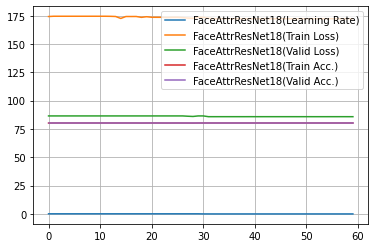

In [18]:
# config.epoch = 1
start_time = time.time()
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = get_criterion()
# criterion = nn.CrossEntropyLoss().to(device)
# print(criterion)
optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
# print(optimizer)
if config.evaluate:
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name)
end_time = time.time()
time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"total time taken: {time_taken}")

In [19]:
# reset_gpu_cache(model,optimizer,criterion, device)

In [20]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    #criterion = nn.CrossEntropyLoss().to(device)
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname config.checkpoint_fname

    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 1)


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.42it/s]

=> Best test accuracy: 79.83756635621177, Model val acc: 80.41463230270537
5_o_Clock_Shadow: 90.01102091761823
Arched_Eyebrows: 71.55595629024859
Attractive: 50.41578998571407
Bags_Under_Eyes: 79.73649933806117
Bald: 97.88097381591797
Bangs: 84.42540824667698
Big_Lips: 67.29786594606045
Big_Nose: 78.79971945322822
Black_Hair: 72.83839295424245
Blond_Hair: 86.67468186043962
Blurry: 94.94038670651362
Brown_Hair: 82.03085860541034
Bushy_Eyebrows: 87.04538622084965
Chubby: 94.69992984457946
Double_Chin: 95.42630995458143
Eyeglasses: 93.54273116403466
Goatee: 95.41629093675812
Gray_Hair: 96.8139464670068
Heavy_Makeup: 59.50305578653947
High_Cheekbones: 48.181544917031815
Male: 61.35156795852183
Mouth_Slightly_Open: 50.49093277035633
Mustache: 96.13265200753379
Narrow_Eyes: 85.13175029962936
No_Beard: 85.36719763736401
Oval_Face: 70.43883376966652
Pale_Skin: 95.79200478085487
Pointy_Nose: 71.42570885751043
Receding_Hairline: 91.51387635515658
Rosy_Cheeks: 92.82637009325897
Sideburns: 95.3611

In [21]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [22]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.6.ipynb to html
[NbConvertApp] Writing 1016469 bytes to ai6126-project1-colab-v0.6.html


        1 file(s) moved.


In [23]:
if config.auto_hibernate and True:
    os.system('shutdown -h')